In [1]:
from calitp.tables import tbl
import calitp.magics
from calitp import query_sql
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import pandas as pd

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(20_000_000_000)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Feasibility of various Littlepay attributes as a proxy for unique riders
(Previous 3 months, up to the last full week)

## Side-by-Side Analysis

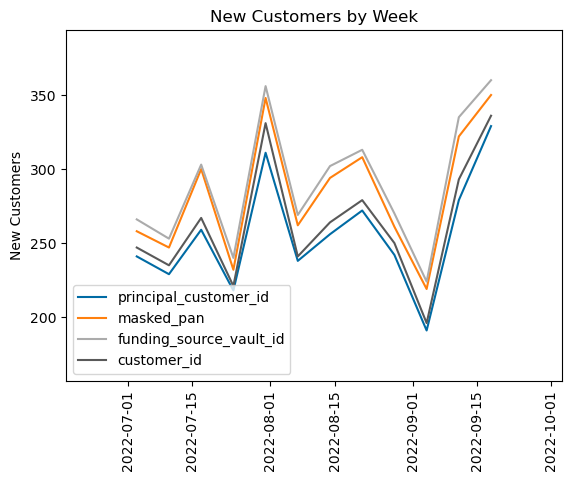

In [10]:
fig, ax = plt.subplots()

ax.plot(principal_customer_id__weekly_comparison['transaction_week'], principal_customer_id__weekly_comparison['first_rides__principal_customer_id'], label="principal_customer_id")
ax.plot(masked_pan__weekly_comparison['transaction_week'], masked_pan__weekly_comparison['first_rides__masked_pan'], label="masked_pan")
ax.plot(funding_source_vault_id__weekly_comparison['transaction_week'], funding_source_vault_id__weekly_comparison['first_rides__funding_source_vault_id'], label="funding_source_vault_id")
ax.plot(customer_id__weekly_comparison['transaction_week'], customer_id__weekly_comparison['first_rides__customer_id'], label="customer_id")
ax.set_ylabel('New Customers')
ax.set_title('New Customers by Week')
plt.xticks(rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
ax.legend()

plt.show()

### Pearson Correlation with `principal_customer_id`

#### vs `customer_id`

In [11]:
data_ci = {'principal_customer_id': principal_customer_id__weekly_comparison['first_rides__principal_customer_id'], 'customer_id': customer_id__weekly_comparison['first_rides__customer_id']}
principal_customer_id__customer_id = pd.DataFrame(data=data_ci)

principal_customer_id__customer_id.corr(method='pearson')

,principal_customer_id,customer_id
principal_customer_id,1.000000,0.996052
customer_id,0.996052,1.000000


#### vs `masked_pan`

In [12]:
data_mp = {'principal_customer_id': principal_customer_id__weekly_comparison['first_rides__principal_customer_id'], 'masked_pan': masked_pan__weekly_comparison['first_rides__masked_pan']}
principal_customer_id__masked_pan = pd.DataFrame(data=data_mp)

principal_customer_id__masked_pan.corr(method='pearson')

,principal_customer_id,masked_pan
principal_customer_id,1.000000,0.974875
masked_pan,0.974875,1.000000


#### vs `funding_source_vault_id`

In [27]:
data_fsvi = {'principal_customer_id': principal_customer_id__weekly_comparison['first_rides__principal_customer_id'], 'funding_source_vault_id': funding_source_vault_id__weekly_comparison['first_rides__funding_source_vault_id']}
principal_customer_id__funding_source_vault_id = pd.DataFrame(data=data_fsvi)

principal_customer_id__funding_source_vault_id.corr(method='pearson')

,principal_customer_id,funding_source_vault_id
principal_customer_id,1.000000,0.977263
funding_source_vault_id,0.977263,1.000000


#### `masked_pan` vs `funding_source_vault_id`?

In [28]:
data_fsvi = {'masked_pan': masked_pan__weekly_comparison['first_rides__masked_pan'], 'funding_source_vault_id': funding_source_vault_id__weekly_comparison['first_rides__funding_source_vault_id']}
masked_pan__funding_source_vault_id = pd.DataFrame(data=data_fsvi)

masked_pan__funding_source_vault_id.corr(method='pearson')

,masked_pan,funding_source_vault_id
masked_pan,1.000000,0.998484
funding_source_vault_id,0.998484,1.000000


### Average Proportion of New Riders, by Agency

#### `principal_customer_id`

In [30]:
principal_customer_id__weekly_comparison__by_agency = query_sql("""
WITH 

customer_first_rides_principal_customer_id AS (
    SELECT
        `principal_customer_id`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `principal_customer_id`
),

count_first_rides_by_agency AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`principal_customer_id`) AS `first_rides__principal_customer_id`
    FROM `customer_first_rides_principal_customer_id`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`principal_customer_id`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
),

count_total_rides AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`views.payments_rides`.`principal_customer_id`) AS `total_rides__principal_customer_id`,
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
)

SELECT
    t1.`participant_id`,
    t2.`total_rides__principal_customer_id`,
    t1.`first_rides__principal_customer_id`,
    ROUND((SAFE_DIVIDE(`first_rides__principal_customer_id`,`total_rides__principal_customer_id`) * 100), 2) AS percent_new_riders
FROM count_first_rides_by_agency AS t1
JOIN count_total_rides AS t2
    USING (`participant_id`, `participant_id`)""", as_df=True)

principal_customer_id__weekly_comparison__by_agency

,participant_id,total_rides__principal_customer_id,first_rides__principal_customer_id,percent_new_riders
0,mst,14064,1655,11.77
1,sbmtd,2761,1235,44.73
2,sacrt,198,147,74.24
3,clean-air-express,3108,124,3.99


#### `masked_pan`

In [29]:
masked_pan__weekly_comparison__by_agency = query_sql("""
WITH 

customer_first_rides_masked_pan AS (
    SELECT
        `masked_pan`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `masked_pan`
),

count_first_rides_by_agency AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`masked_pan`) AS `first_rides__masked_pan`
    FROM `customer_first_rides_masked_pan`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`masked_pan`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
),

count_total_rides AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`views.payments_rides`.`masked_pan`) AS `total_rides__masked_pan`,
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
)

SELECT
    t1.`participant_id`,
    t2.`total_rides__masked_pan`,
    t1.`first_rides__masked_pan`,
    ROUND((SAFE_DIVIDE(`first_rides__masked_pan`,`total_rides__masked_pan`) * 100), 2) AS percent_new_riders
FROM count_first_rides_by_agency AS t1
JOIN count_total_rides AS t2
    USING (`participant_id`, `participant_id`)""", as_df=True)

masked_pan__weekly_comparison__by_agency

,participant_id,total_rides__masked_pan,first_rides__masked_pan,percent_new_riders
0,mst,14064,1930,13.72
1,sbmtd,2761,1280,46.36
2,sacrt,198,148,74.75
3,clean-air-express,3108,145,4.67


#### `funding_source_vault_id`

In [16]:
funding_source_vault_id__weekly_comparison__by_agency = query_sql("""
WITH 

customer_first_rides_funding_source_vault_id AS (
    SELECT
        `funding_source_vault_id`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `funding_source_vault_id`
),

count_first_rides_by_agency AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`funding_source_vault_id`) AS `first_rides__funding_source_vault_id`
    FROM `customer_first_rides_funding_source_vault_id`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`funding_source_vault_id`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
),

count_total_rides AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`views.payments_rides`.`funding_source_vault_id`) AS `total_rides__funding_source_vault_id`,
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
)

SELECT
    t1.`participant_id`,
    t2.`total_rides__funding_source_vault_id`,
    t1.`first_rides__funding_source_vault_id`,
    ROUND((SAFE_DIVIDE(`first_rides__funding_source_vault_id`,`total_rides__funding_source_vault_id`) * 100), 2) AS percent_new_riders
FROM count_first_rides_by_agency AS t1
JOIN count_total_rides AS t2
    USING (`participant_id`, `participant_id`)""", as_df=True)

funding_source_vault_id__weekly_comparison__by_agency

,participant_id,total_rides__funding_source_vault_id,first_rides__funding_source_vault_id,percent_new_riders
0,mst,14064,1990,14.15
1,sbmtd,2761,1302,47.16
2,sacrt,198,157,79.29
3,clean-air-express,3108,146,4.70


#### `customer_id`

In [17]:
customer_id__weekly_comparison__by_agency = query_sql("""
WITH 

customer_first_rides_customer_id AS (
    SELECT
        `customer_id`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `customer_id`
),

count_first_rides_by_agency AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`customer_id`) AS `first_rides__customer_id`
    FROM `customer_first_rides_customer_id`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`customer_id`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
),

count_total_rides AS (
    SELECT
        `views.payments_rides`.`participant_id`,
        count(`views.payments_rides`.`customer_id`) AS `total_rides__customer_id`,
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `participant_id`
)

SELECT
    t1.`participant_id`,
    t2.`total_rides__customer_id`,
    t1.`first_rides__customer_id`,
    ROUND((SAFE_DIVIDE(`first_rides__customer_id`,`total_rides__customer_id`) * 100), 2) AS percent_new_riders
FROM count_first_rides_by_agency AS t1
JOIN count_total_rides AS t2
    USING (`participant_id`, `participant_id`)""", as_df=True)

customer_id__weekly_comparison__by_agency

,participant_id,total_rides__customer_id,first_rides__customer_id,percent_new_riders
0,mst,14064,1664,11.83
1,sbmtd,2761,1302,47.16
2,sacrt,198,147,74.24
3,clean-air-express,3108,146,4.70


## Individual Analysis

### `principal_customer_id`

In [18]:
principal_customer_id__weekly_comparison = query_sql("""
WITH 

customer_first_rides_principal_customer_id AS (
    SELECT
        `principal_customer_id`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `principal_customer_id`
),

week_id_join AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        count(`principal_customer_id`) AS `first_rides__principal_customer_id`
    FROM `customer_first_rides_principal_customer_id`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`principal_customer_id`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

total_rides_per_week AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        COUNT(*) AS total_weekly_count
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

join_first_ride_and_total AS (
    SELECT
        `t1`.`transaction_week`,
        `t1`.`first_rides__principal_customer_id`,
        `t2`.`total_weekly_count`
    FROM `week_id_join` AS `t1`
    JOIN `total_rides_per_week` AS `t2`
        USING (`transaction_week`, `transaction_week`)
    ORDER BY `transaction_week` DESC
),

calculate_percentage AS (
    SELECT
        *,
        ROUND((SAFE_DIVIDE(`first_rides__principal_customer_id`,`total_weekly_count`) * 100), 2) AS percent_new_riders
    FROM join_first_ride_and_total
)

SELECT
    transaction_week,
    first_rides__principal_customer_id,
    total_weekly_count,
    percent_new_riders
FROM 
    (SELECT
        *,
        ROW_NUMBER() OVER(ORDER BY transaction_week DESC) AS row_number
    FROM calculate_percentage)
WHERE row_number!=1""", as_df=True)

principal_customer_id__weekly_comparison

,transaction_week,first_rides__principal_customer_id,total_weekly_count,percent_new_riders
0,2022-09-18,329,1894,17.37
1,2022-09-11,279,2007,13.90
2,2022-09-04,191,1305,14.64
3,2022-08-28,242,1670,14.49
4,2022-08-21,272,1752,15.53
5,2022-08-14,256,1673,15.30
6,2022-08-07,238,1691,14.07
7,2022-07-31,311,1823,17.06
8,2022-07-24,218,1388,15.71
9,2022-07-17,259,1733,14.95


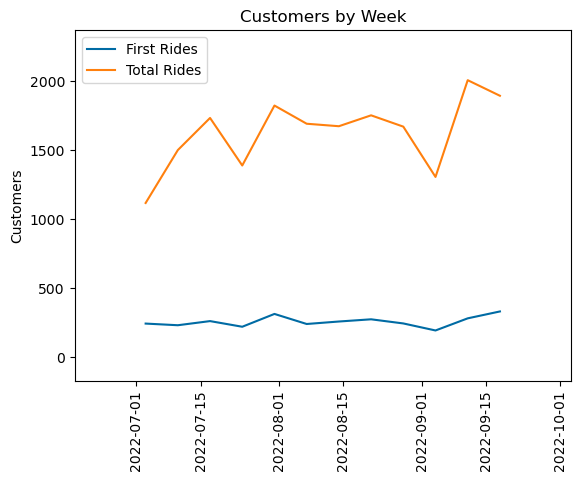

In [19]:
fig, ax = plt.subplots()

ax.plot(principal_customer_id__weekly_comparison['transaction_week'], principal_customer_id__weekly_comparison['first_rides__principal_customer_id'], label="First Rides")
ax.plot(principal_customer_id__weekly_comparison['transaction_week'], principal_customer_id__weekly_comparison['total_weekly_count'], label="Total Rides")

ax.set_ylabel('Customers')
ax.set_title('Customers by Week')
plt.xticks(rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
ax.legend()

plt.show()


### `masked_pan`

In [20]:
masked_pan__weekly_comparison = query_sql("""
WITH 

customer_first_rides_masked_pan AS (
    SELECT
        `masked_pan`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `masked_pan`
),

week_id_join AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        count(`masked_pan`) AS `first_rides__masked_pan`
    FROM `customer_first_rides_masked_pan`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`masked_pan`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

total_rides_per_week AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        COUNT(*) AS total_weekly_count
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

join_first_ride_and_total AS (
    SELECT
        `t1`.`transaction_week`,
        `t1`.`first_rides__masked_pan`,
        `t2`.`total_weekly_count`
    FROM `week_id_join` AS `t1`
    JOIN `total_rides_per_week` AS `t2`
        USING (`transaction_week`, `transaction_week`)
    ORDER BY `transaction_week` DESC
),

calculate_percentage AS (
    SELECT
        *,
        ROUND((SAFE_DIVIDE(`first_rides__masked_pan`,`total_weekly_count`) * 100), 2) AS percent_new_riders
    FROM join_first_ride_and_total
)

SELECT
    transaction_week,
    first_rides__masked_pan,
    total_weekly_count,
    percent_new_riders
FROM 
    (SELECT
        *,
        ROW_NUMBER() OVER(ORDER BY transaction_week DESC) AS row_number
    FROM calculate_percentage)
WHERE row_number!=1""", as_df=True)

masked_pan__weekly_comparison

,transaction_week,first_rides__masked_pan,total_weekly_count,percent_new_riders
0,2022-09-18,350,1894,18.48
1,2022-09-11,322,2007,16.04
2,2022-09-04,219,1305,16.78
3,2022-08-28,261,1670,15.63
4,2022-08-21,308,1752,17.58
5,2022-08-14,294,1673,17.57
6,2022-08-07,262,1691,15.49
7,2022-07-31,348,1823,19.09
8,2022-07-24,232,1388,16.71
9,2022-07-17,300,1733,17.31


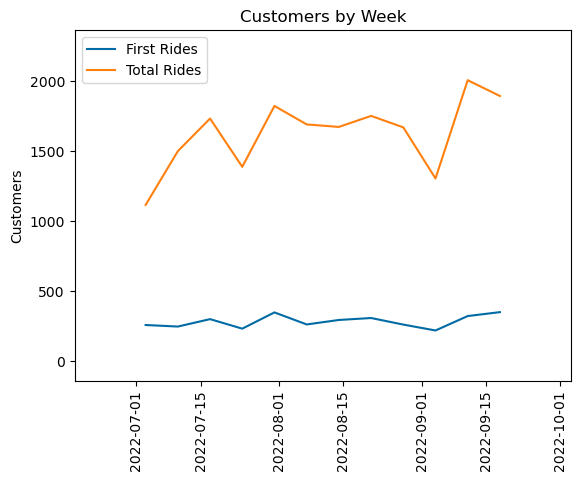

In [21]:
fig, ax = plt.subplots()

ax.plot(masked_pan__weekly_comparison['transaction_week'], masked_pan__weekly_comparison['first_rides__masked_pan'], label="First Rides")
ax.plot(masked_pan__weekly_comparison['transaction_week'], masked_pan__weekly_comparison['total_weekly_count'], label="Total Rides")

ax.set_ylabel('Customers')
ax.set_title('Customers by Week')
plt.xticks(rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
ax.legend()

plt.show()

### `funding_source_vault_id`

In [22]:
funding_source_vault_id__weekly_comparison = query_sql("""
WITH 

customer_first_rides_funding_source_vault_id AS (
    SELECT
        `funding_source_vault_id`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `funding_source_vault_id`
),

week_id_join AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        count(`funding_source_vault_id`) AS `first_rides__funding_source_vault_id`
    FROM `customer_first_rides_funding_source_vault_id`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`funding_source_vault_id`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

total_rides_per_week AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        COUNT(*) AS total_weekly_count
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

join_first_ride_and_total AS (
    SELECT
        `t1`.`transaction_week`,
        `t1`.`first_rides__funding_source_vault_id`,
        `t2`.`total_weekly_count`
    FROM `week_id_join` AS `t1`
    JOIN `total_rides_per_week` AS `t2`
        USING (`transaction_week`, `transaction_week`)
    ORDER BY `transaction_week` DESC
),

calculate_percentage AS (
    SELECT
        *,
        ROUND((SAFE_DIVIDE(`first_rides__funding_source_vault_id`,`total_weekly_count`) * 100)) AS percent_new_riders
    FROM join_first_ride_and_total
)

SELECT
    transaction_week,
    first_rides__funding_source_vault_id,
    total_weekly_count,
    percent_new_riders
FROM 
    (SELECT
        *,
        ROW_NUMBER() OVER(ORDER BY transaction_week DESC) AS row_number
    FROM calculate_percentage)
WHERE row_number!=1""", as_df=True)

funding_source_vault_id__weekly_comparison

,transaction_week,first_rides__funding_source_vault_id,total_weekly_count,percent_new_riders
0,2022-09-18,360,1894,19.0
1,2022-09-11,335,2007,17.0
2,2022-09-04,224,1305,17.0
3,2022-08-28,270,1670,16.0
4,2022-08-21,313,1752,18.0
5,2022-08-14,302,1673,18.0
6,2022-08-07,269,1691,16.0
7,2022-07-31,356,1823,20.0
8,2022-07-24,240,1388,17.0
9,2022-07-17,303,1733,17.0


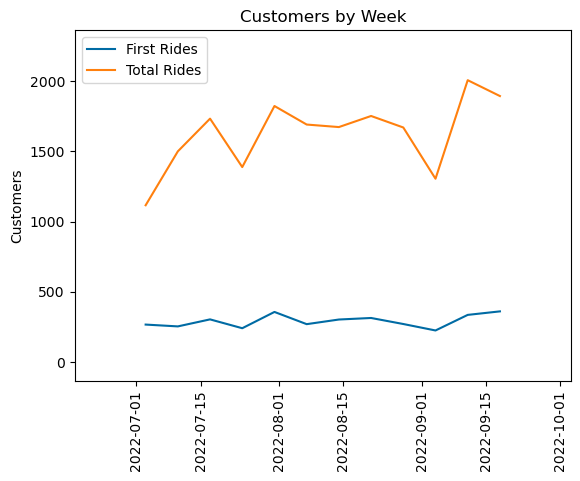

In [23]:
fig, ax = plt.subplots()

ax.plot(funding_source_vault_id__weekly_comparison['transaction_week'], funding_source_vault_id__weekly_comparison['first_rides__funding_source_vault_id'], label="First Rides")
ax.plot(funding_source_vault_id__weekly_comparison['transaction_week'], funding_source_vault_id__weekly_comparison['total_weekly_count'], label="Total Rides")

ax.set_ylabel('Customers')
ax.set_title('Customers by Week')
plt.xticks(rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
ax.legend()

plt.show()

### `customer_id`

In [24]:
customer_id__weekly_comparison = query_sql("""
WITH 

customer_first_rides_customer_id AS (
    SELECT
        `customer_id`,
        MIN(`transaction_date_time_pacific`) AS `transaction_date_time_pacific`
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `customer_id`
),

week_id_join AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        count(`customer_id`) AS `first_rides__customer_id`
    FROM `customer_first_rides_customer_id`
    JOIN `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
        USING (`customer_id`, `transaction_date_time_pacific`)  -- Chances for fanout here are pretty small; the join is only necessary so that we can use the filter variable below.
    WHERE datetime_trunc(`transaction_date_time_pacific`, week(sunday)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 3 MONTH)
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

total_rides_per_week AS (
    SELECT
        datetime_trunc(`transaction_date_time_pacific`, week(sunday)) AS `transaction_week`,
        COUNT(*) AS total_weekly_count
    FROM `cal-itp-data-infra.views.payments_rides` AS `views.payments_rides`
    GROUP BY `transaction_week`
    ORDER BY `transaction_week` DESC
),

join_first_ride_and_total AS (
    SELECT
        `t1`.`transaction_week`,
        `t1`.`first_rides__customer_id`,
        `t2`.`total_weekly_count`
    FROM `week_id_join` AS `t1`
    JOIN `total_rides_per_week` AS `t2`
        USING (`transaction_week`, `transaction_week`)
    ORDER BY `transaction_week` DESC
),

calculate_percentage AS (
    SELECT
        *,
        ROUND((SAFE_DIVIDE(`first_rides__customer_id`,`total_weekly_count`) * 100), 2) AS percent_new_riders
    FROM join_first_ride_and_total
)

SELECT
    transaction_week,
    first_rides__customer_id,
    total_weekly_count,
    percent_new_riders
FROM 
    (SELECT
        *,
        ROW_NUMBER() OVER(ORDER BY transaction_week DESC) AS row_number
    FROM calculate_percentage)
WHERE row_number!=1""", as_df=True)

customer_id__weekly_comparison

,transaction_week,first_rides__customer_id,total_weekly_count,percent_new_riders
0,2022-09-18,336,1894,17.74
1,2022-09-11,293,2007,14.60
2,2022-09-04,196,1305,15.02
3,2022-08-28,250,1670,14.97
4,2022-08-21,279,1752,15.92
5,2022-08-14,264,1673,15.78
6,2022-08-07,241,1691,14.25
7,2022-07-31,331,1823,18.16
8,2022-07-24,221,1388,15.92
9,2022-07-17,267,1733,15.41


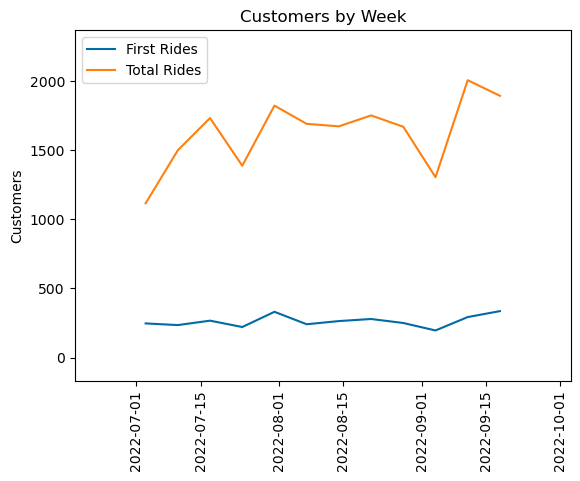

In [25]:
fig, ax = plt.subplots()

ax.plot(customer_id__weekly_comparison['transaction_week'], customer_id__weekly_comparison['first_rides__customer_id'], label="First Rides")
ax.plot(customer_id__weekly_comparison['transaction_week'], customer_id__weekly_comparison['total_weekly_count'], label="Total Rides")

ax.set_ylabel('Customers')
ax.set_title('Customers by Week')
plt.xticks(rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
ax.legend()

plt.show()

## Other investigation

> Maybe try taking a closer look at the original query Mjumbe wrote that was servicing this question.

The original query. Fanout based on `principal_customer_id` and `transaction_date_time_pactific` does seem pretty small, as noted in the query below.

> Then if you're comfortable, you can also take a look upstream at the tasks that generate the payments_rides table to see if there's anywhere fan out could be introduced from principal_customer_id

Most staging tables seem unlikley to introduce fanout. Some that might:
* `stg_cleaned_micropayment_device_transactions`
* `stg_cleaned_device_transaction_types`


or 
* `payments_rides` itself ??


or, from Mjumbe:
* stg_cleaned_customer_funding_source
* stg_cleaned_customer_funding_source_vaults

^ these are the biggest places that we made assumptions that could use validation
`cleaned customers` depends on the`stg_enriched_customer_funding_source` model as does the `stg_cleaned_customer_funding_source_vaults`. In both of these models, we're accounting for which ids should be included from the `stg_enriched_customer_funding_source.sql` models in different ways

the different ways at a high level:
* stg_cleaned_customers table
    * takes `customer_id` from `stg_enriched_customer_funding_source` that is from the most recent extract date (`calitp_customer_id_rank = 1`)
* stg_cleaned_customer_funding_source_vaults
    * also takes `customer_id` from `stg_enriched_customer_funding_source` that is from the most recent extract date  (`calitp_customer_id_rank = 1`)
^ These are both because this is because we need `customer_id` to join to other tables to get `principal_customer_id`, which we anticipated as being the most useful/accurate attribute. `customer_id` exists in (nearly?) every table, `principal_customer_id` does not. so we try to persist `principal_customer_id` out.
    
    
**big assumption**: which `customer_id` are we selecting from and why?? there are numerous `customer_id` per `principal_customer_id`, so we're ranking by extract date upstrean to get `customer_id` from the most recent extraction, but is that correct?? 
the core problem brin that many tables don't have `principal_customer_id`, only `customer_id`, so we need to keep `customer_id` for joins, but which one?? again, we've just been taking the most recent export date